In [1]:
## Figure 1 & 2 - Performance Evaluation of Different Weight Functions on Network Inversion with Simulations

import os
import sys
import numpy as np
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
import pysar.simulation as psim
from pysar.simulation.plot import *
from pysar.utils import ptime, readfile, writefile, utils as ut, network as pnet, plot as pp
from pysar.objects import timeseries, ifgramStack, sensor
import pysar.ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/simNetworkInv_weightFunc')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
sensorName = sensor.project_name2sensor_name(os.path.join(work_dir, 'AlcedoSenDT128'))[0]

weight_functions = ['Uniform', 'Coherence', 'Variance inv', 'Fisher info']

# Time-series Setup
ts_obj = timeseries(os.path.join(work_dir, 'AlcedoSenDT128/timeseries.h5'))
ts_obj.open()
ts_obj.save2bl_list_file(out_file='bl_list.txt')

tbase = np.array(ts_obj.tbase)
tbase_diff = np.diff(np.array(tbase, dtype=np.float32) / 365.25).reshape(-1, 1)
ts_sim = psim.sim_variable_timeseries(tbase, display=False)

date_list = ts_obj.dateList
dates, datevector = ptime.date_list2vector(date_list)

inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# Network Setup
num_conn = 10
date12_list = pnet.select_pairs_sequential(date_list, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
stack_obj = ifgramStack(os.path.join(work_dir, 'AlcedoSenDT128/ifgramStack.h5'))
A, B = stack_obj.get_design_matrix4timeseries_estimation(date12_list=date12_list)
print('number of ifgrams: {}'.format(len(date12_list)))

## Decorrelation Noise Setup
coh_resid = 0.1
decor_time = 50.
num_sample = 10000
L = 3 * 9

L_max = 80
out_file = 'netInvRms_minVel_L{:d}'.format(L_max)
print('output file base: '+out_file)
print('Done.')

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/simNetworkInv_weightFunc
open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
number of ifgrams: 925
output file base: netInvRms_minVel_L80
Done.


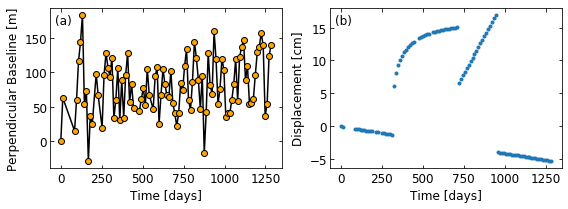

In [60]:
## Figure S1 - Time-series Setup
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

axs[0].plot(tbase, ts_obj.pbase, '-ko', mfc='orange')
axs[0].set_ylabel('Perpendicular Baseline [m]', fontsize=font_size)

axs[1].plot(tbase, ts_sim * 100., '.')
axs[1].set_ylabel('Displacement [cm]', fontsize=font_size)

for ax, num in zip(axs, ['(a)', '(b)']):
    ax.set_xlabel('Time [days]', fontsize=font_size)
    ax.annotate(num, xy=(0.02, 0.9), color='k', xycoords='axes fraction', fontsize=font_size)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.tight_layout()

fig.savefig('timeseries_setup.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [2]:
## Run Demo Simulation
ifgram_est, coh_est, ifgram_sim, coh_sim = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                                 L=L, num_sample=num_sample,
                                                                 baseline_file='bl_list.txt',
                                                                 sensor_name=sensorName,
                                                                 inc_angle=inc_angle)
ifg_est_mat = pnet.coherence_matrix(date12_list, ifgram_est[:,0])
ifg_sim_mat = pnet.coherence_matrix(date12_list, ifgram_sim[:,0])
print('Done.')

Done.


In [44]:
ifgram_est.shape

(925, 10000)

In [47]:
np.mean(ifgram_est, axis=0).shape

(10000,)

In [43]:
np.exp(1j*1.5*np.pi)

(-1.8369701987210297e-16-1j)

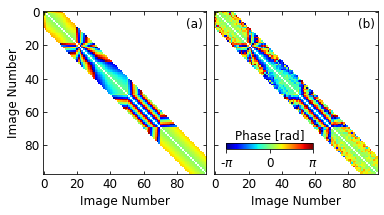

In [12]:
## Figure S2 - Noise-free and noisy phase
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 3], sharey=True)
for ax, data, num in zip(axs, [ifg_sim_mat, ifg_est_mat], ['(a)', '(b)']):
    im = ax.imshow(ut.wrap(data), vmin=-1*np.pi, vmax=np.pi, cmap='jet')
    ax.set_xlabel('Image Number', fontsize=font_size)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    ax.annotate(num, xy=(0.88, 0.9), color='k', xycoords='axes fraction', fontsize=font_size)
axs[0].set_ylabel('Image Number', fontsize=font_size)

fig.subplots_adjust(wspace=0.05)
# colorbar
cax = fig.add_axes([0.55, 0.24, 0.2, 0.03])
cbar = plt.colorbar(im, cax=cax, ticks=[-np.pi, 0, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'], fontsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top')

fig.savefig('phase_simulation.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

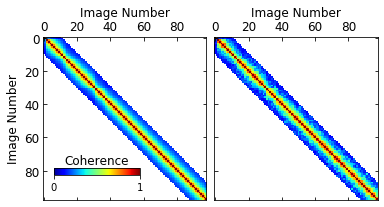

In [19]:
## Figure 1 - Simulated coherence and coherence estimation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 3], sharey=True)
for ax, data, num in zip(axs, [coh_sim, coh_est], ['(a)', '(b)']):
    im = ax.imshow(pnet.coherence_matrix(date12_list, data, diag_value=1.), vmin=0, vmax=1, cmap='jet')
    # axis format
    ax.xaxis.tick_top()
    ax.set_xlabel('Image Number', fontsize=font_size)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    #ax.annotate(num, xy=(0.88, 0.9), color='k', xycoords='axes fraction', fontsize=font_size)
axs[0].set_ylabel('Image Number', fontsize=font_size)

fig.subplots_adjust(wspace=0.05)
# colorbars
cax = fig.add_axes([0.15, 0.24, 0.2, 0.03])
cbar = plt.colorbar(im, cax=cax, ticks=[0, 1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top') 

fig.savefig('coherence_simulation.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [48]:
## Run Comparison for Figure 2 - Get RMSE of estimated Time-series from inversion with different weight functions
def get_network_inversion_rms(ifgram, coh_data, L, min_norm_velocity=True, print_msg=True):
    """Get inversion RMS from truth for different weight functions"""
    num = len(weight_functions)
    rms = np.zeros(num, np.float32)
    for i in range(num):
        weight_func = weight_functions[i]
        weight = ifginv.coherence2weight(coh_data, weight_func=weight_func, L=L, print_msg=False)
        if weight is not None:
            weight = np.sqrt(weight)
        ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram, weight_sqrt=weight,
                                            min_norm_velocity=min_norm_velocity)[0]
        ts_diff = ts_inv - np.tile(ts_sim.reshape(-1,1), (1, num_sample)) / phase2range
        rms[i] = np.mean(np.sqrt(np.mean(np.square(ts_diff), axis=0)))
        #rms[i] = np.sqrt(np.mean(ts_diff**2))
        if print_msg:
            print('Weight function {} with RMS: {} radian'.format(weight_func, rms[i]))
    return rms, ts_inv

def get_rms_inv(min_norm_velocity=True, L_step=1, L_max=20):
    #xx = np.arange(d_step, d_max+d_step, step=d_step, dtype=np.int16).reshape(-1, 1)
    xx = np.arange(L_step, L_max+L_step, step=L_step, dtype=np.int16).reshape(-1, 1)
    rms_inv = np.zeros((xx.size, len(weight_functions)), np.float32)
    print('residual coherence: {}'.format(coh_resid))
    print('decorrelation time: {} days'.format(decor_time))
    for i in range(xx.size):
        ifgram_est, coh_est = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                    L=int(xx[i]), num_sample=num_sample,
                                                    baseline_file='bl_list.txt',
                                                    sensor_name=sensorName,
                                                    inc_angle=inc_angle)[0:2]
        rms_inv[i, :] = get_network_inversion_rms(ifgram_est, coh_est, L=int(xx[i]),
                                                  min_norm_velocity=min_norm_velocity,
                                                  print_msg=False)[0]
        sys.stdout.write('\r{}/{}'.format(i+1, xx.size))
        sys.stdout.flush()
    print('')
    return xx, rms_inv

run_compare = True
## calculate RMS of network inversion
if run_compare:
    xx, rms_inv = get_rms_inv(L_max=L_max)
    np.save(out_file, np.hstack((xx, rms_inv)))
print('Done.')

residual coherence: 0.1
decorrelation time: 50.0 days
80/80
Done.


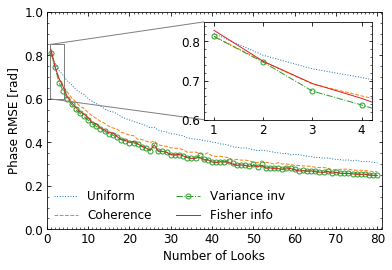

In [17]:
## Figure 2 - RMSE of estimated time-series from inversion with different weight functions

# read data
fcontent = np.load('{}.npy'.format(out_file))
xx = fcontent[:, 0].reshape(-1, 1)
rms_inv = fcontent[:, 1:]

# plot
marker_list = [':', '--', '-.o', '-']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 4])
ax2 = inset_axes(ax, width='50%', height='45%', loc='upper right', borderpad=1.)  ## add insert rectangle
for i in range(len(weight_functions)):
    for axi in [ax, ax2]:
        axi.plot(xx.reshape(-1, 1), rms_inv[:, i], marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])
mark_inset(ax, ax2, loc1=2, loc2=3, fc="none", ec="0.5")

# axis format
ax.set_ylabel('Phase RMSE [rad]', fontsize=font_size)
ax.set_xlabel('Number of Looks', fontsize=font_size)
ax.set_xlim((0., np.max(xx)+1))
ax.set_ylim((0., 1.))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.legend(loc='lower left', ncol=2, fontsize=font_size, frameon=False, borderpad=0.1)

ax2.set_xlim(0.8, 4.2)
ax2.set_ylim(0.6, 0.85)
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))

for axi in [ax, ax2]:
    axi.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    axi.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
plt.savefig('{}.png'.format(out_file), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [10]:
coh_resid = 0.6
decor_time = 200.

## calculate RMS of network inversion
xx, rms_inv = get_rms_inv(min_norm_velocity=min_norm_velocity, L_max=50)
#np.save(out_file, np.hstack((xx, rms_inv)))



residual coherence: 0.6
decorrelation time: 200.0 days
50/50


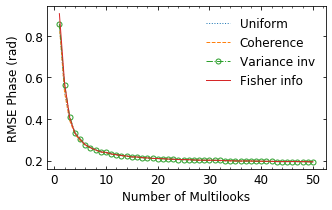

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 3])

for i in range(len(weight_functions)):
    ax.plot(xx.reshape(-1, 1), rms_inv[:, i], marker_list[i], lw=1,
            ms=5, mfc='none', label=weight_functions[i])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax.set_xlim((0, np.max(xx)+1))
#ax.set_ylim(bottom=0.)

#ax.set_xlim([0, 10])
#ax.set_ylim([0.6, 1.6])
ax.set_xlabel('Number of Multilooks', fontsize=font_size)
ax.set_ylabel('RMSE Phase (rad)', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)
plt.savefig('test.jpg'.format(out_file), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

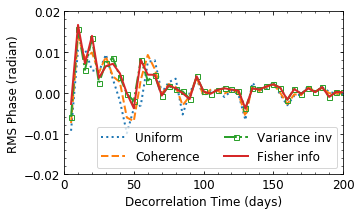

In [43]:
fig, ax = plt.subplots(figsize=[5, 3])
for i in range(len(weight_functions)):
    ax.plot(decor_time.reshape(-1, 1), rms_inv_minVel[:, i] - rms_inv_minPha[:, i], marker_list[i], lw=2,
            ms=5, mfc='none', label=weight_functions[i])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim((0, 200))
ax.set_ylim((-0.02, 0.02))
plt.xlabel('Decorrelation Time (days)', fontsize=font_size)
plt.ylabel('RMS Phase (radian)', fontsize=font_size)
plt.legend(fontsize=font_size, ncol=2)
plt.savefig('netInv_rms_minVel-minPha.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

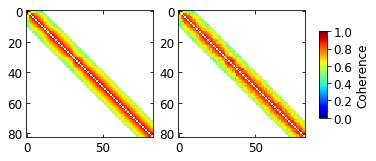

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[5, 3])
for ax, data in zip(axs, [coh_sim, coh_est]):
    data_mat = pnet.coherence_matrix(date12_list, data)
    im = ax.imshow(data_mat, vmin=0, vmax=1., cmap='jet')
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.94, 0.3, 0.02, 0.4])
cbar = plt.colorbar(im, cax)
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.savefig('')
plt.show()

In [54]:
cbar.ax

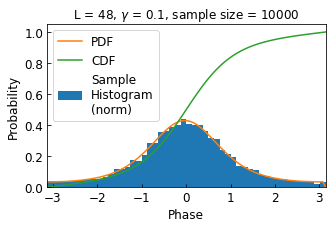

In [7]:
x = psim.sample_decorrelation_phase(L, 0.1, size=int(1e4), display=True)

In [14]:
np.arange(10, 1000, step=10).size

99

In [16]:
filec = np.load('{}.npy'.format(out_file))
filec[:, 0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.],
      dtype=float32)